In [14]:
#Notebooks for small tests
import os  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
#imports and plotting function
import argparse
import mat73
import logging
import numpy as np
#import torchvision
from datetime import datetime
import os
import scipy.io
from torch.utils.data import DataLoader
import io
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import wandb
import math
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn as nn
import torch
import sys
import torch.optim.lr_scheduler as lr_scheduler
import wandb
import torch
from sklearn.preprocessing import StandardScaler
import Models as M
import Helpers as H
import time
import copy
from torch.func import vmap
from functorch.experimental import replace_all_batch_norm_modules_
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance_matrix
from sklearn.cluster import DBSCAN


%matplotlib inline

encoder_out='sigmoid'
cwd=os. getcwd()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
unlabeled_data=5000
if False: #This vlock is from betas sweep. good betas. Not optimal.
    decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Classic_gelma/decoder_5000_0_'
    timescampstrs={'07-14-29','09-46-07','14-35-38','13-49-42','09-45-53'} #they located in above or below
    #            curr_decoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Classic_gelma/decoder_5000_1'+curr_decoder[-12:]



if True:#This block is from tests done with all default (pytorch) parameters


    decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_'
    timescampstrs = [
    "44_00-31-12",
    "47_00-31-10",
    "43_18-10-40",
    "46_18-10-39",
    "41_18-10-04",
    "49_18-00-09",
    "48_11-52-40",
    "45_11-50-38",
    "42_11-50-21",
    "40_11-49-46",
    "25_8-6-24",
    "24_01-54-27",
    "9_21-43-17",
    "4_21-42-58",
    "23_17-55-08",
    "29_15-29-37",
    "39_15-11-34",
    "34_15-09-31",
    "8_13-43-00",
    "3_13-42-41",
    "22_09-55-47",
    "38_08-50-47",
    "33_08-47-54",
    "28_08-46-30",
    "7_05-43-01",
    "2_05-42-47",
    "37_02-29-47",
    "32_2-26-51",
    "27_2-25-22",
    "21_01-56-27",
    "6_21-43-02",
    "1_21-42-47",
    "36_20-08-25",
    "31_20-05-29",
    "26_20-04-14",
    "20_17-57-14",
    "35_13-47-33",
    "30_13-44-32",
    "5_13-43-10",
    "0_13-42-53",
    "19_11-58-46",
    "18_8-27-31",
    "17_5-3-27",
    "16_01-39-09",
    "15_22-14-51",
    "14_17-34-09",
    "13_12-36-21",
    "12_9-12-21",
    "11_05-47-25",
    "10_1-9-58"
]

#,'21-52-00','01-44-08','05-09-23','01-48-20', '09-27-26','05-27-23','08-57-23','03-35-41'}


pixels='Gaussian_abs'


decoder_locats=[decoder_locats+timescampstr+'.pt' for timescampstr in timescampstrs]
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000,pixels=pixels, normalize=False)
indim=int(training_data.b[0].shape[0]/2)
outdim=(training_data.rho[0].shape[0]/4)
def get_cluster_data(decoder_locats):
    Complex_eye=torch.cat((torch.eye(int(outdim*2)), torch.zeros((int(outdim*2),int(outdim*2)))), dim=1)

    #Complex_eye=torch.eye(400)#.to(device)
    columns=[]
    
    #decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    for curr_decoder in decoder_locats:
        decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}

        #decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
        try:
            decoder.load_state_dict(torch.load(curr_decoder))
        except:
            #curr_decoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Classic_gelma/decoder_5000_1'+curr_decoder[-12:]
            #decoder.load_state_dict(torch.load(curr_decoder))
            pass
        medium_hat=decoder(Complex_eye).squeeze()
        #print(medium_hat.shape)
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        columns.append(medium_hat)
    columns=np.array(columns)
    return  np.row_stack(columns)


col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(361):
    G_i=medium.T[i]
    print(G_i.shape)
    break

def db_inner(a,b):
    a=H.cat2complex(a)
    b=H.cat2complex(b)
    return 1-abs(np.inner(a,b.conj()))
X=col_list
X = np.concatenate([X.real, X.imag], axis=1)
columns=X
num_clusters=[]
eps_linspace=np.linspace(.0001,.5,1000)
torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))

for eps in eps_linspace:
    DBSCAN_fit=DBSCAN(eps=eps, min_samples=5, metric='precomputed').fit(torch_inner)

    DBSCAN_fit.labels_
    X_clustered=X[DBSCAN_fit.labels_!=-1]
    len(X_clustered)
    cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
    #dist_in_cluster=[]
    #for i in range(max(DBSCAN_fit.labels_)):
        #X_in_cluster=X[DBSCAN_fit.labels_==i]
        #dist_matrix=distance_matrix(X_in_cluster, X_in_cluster)
        #max_dist_in_cluster=np.max(dist_matrix)
        #dist=sum((X_in_cluster[0]-X_in_cluster[1])**2)**(1/2)
        #dist_in_cluster.append(max_dist_in_cluster)
    # if len(X[DBSCAN_fit.labels_==i])>1:
    #     dist_in_cluster.append(np.mean(np.sum((X[DBSCAN_fit.labels_==i]-np.mean(X[DBSCAN_fit.labels_==i], axis=0))**2, axis=1))
    # else:
    #     dist_in_cluster.append(0)
    #dist_in_cluster#=[np.mean(np.sum((X[DBSCAN_fit.labels_==i]-np.mean(X[DBSCAN_fit.labels_==i], axis=0))**2, axis=1)) for i in range(max(DBSCAN_fit.labels_))]
    #dist_in_cluster.sort()
    #plt.plot([i for i in range(len(dist_in_cluster))], dist_in_cluster)
    num_clusters.append(len(cluster_sizes))
    #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
plt.plot(eps_linspace, num_clusters, label='DBSCAN number of clusters')
plt.hlines(19**2, eps_linspace[0],eps_linspace[-1], colors='r', linestyles='dashed', label='True number of columns')

(806, 361)
(361, 361)
coherence of data:  0.763143828697641
Medium: (806, 361), Rho: (5000, 361), B: (5000, 806)
shape of the union without removin: (18050, 806), number for Expceriments: 50
(806,)


(806, 361)
(361, 361)
coherence of data:  0.763143828697641
Medium: (806, 361), Rho: (5000, 361), B: (5000, 806)
shape of the union without removin: (18050, 806), number for Expceriments: 50
(806,)


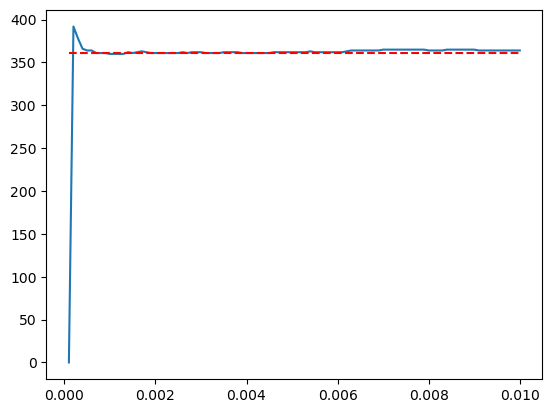

In [6]:
#Notebooks for small tests
import os  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
#imports and plotting function
import argparse
import mat73
import logging
import numpy as np
#import torchvision
from datetime import datetime
import os
import scipy.io
from torch.utils.data import DataLoader
import io
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import wandb
import math
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn as nn
import torch
import sys
import torch.optim.lr_scheduler as lr_scheduler
import wandb
import torch
from sklearn.preprocessing import StandardScaler
import Models as M
import Helpers as H
import time
import copy
from torch.func import vmap
from functorch.experimental import replace_all_batch_norm_modules_
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance_matrix
from sklearn.cluster import DBSCAN


%matplotlib inline

encoder_out='sigmoid'
cwd=os. getcwd()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
unlabeled_data=5000
if False: #This vlock is from betas sweep. good betas. Not optimal.
    decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Classic_gelma/decoder_5000_0_'
    timescampstrs={'07-14-29','09-46-07','14-35-38','13-49-42','09-45-53'} #they located in above or below
    #            curr_decoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Classic_gelma/decoder_5000_1'+curr_decoder[-12:]



if True:#This block is from tests done with all default (pytorch) parameters


    decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_'
    timescampstrs = [
    "44_00-31-12",
    "47_00-31-10",
    "43_18-10-40",
    "46_18-10-39",
    "41_18-10-04",
    "49_18-00-09",
    "48_11-52-40",
    "45_11-50-38",
    "42_11-50-21",
    "40_11-49-46",
    "25_8-6-24",
    "24_01-54-27",
    "9_21-43-17",
    "4_21-42-58",
    "23_17-55-08",
    "29_15-29-37",
    "39_15-11-34",
    "34_15-09-31",
    "8_13-43-00",
    "3_13-42-41",
    "22_09-55-47",
    "38_08-50-47",
    "33_08-47-54",
    "28_08-46-30",
    "7_05-43-01",
    "2_05-42-47",
    "37_02-29-47",
    "32_2-26-51",
    "27_2-25-22",
    "21_01-56-27",
    "6_21-43-02",
    "1_21-42-47",
    "36_20-08-25",
    "31_20-05-29",
    "26_20-04-14",
    "20_17-57-14",
    "35_13-47-33",
    "30_13-44-32",
    "5_13-43-10",
    "0_13-42-53",
    "19_11-58-46",
    "18_8-27-31",
    "17_5-3-27",
    "16_01-39-09",
    "15_22-14-51",
    "14_17-34-09",
    "13_12-36-21",
    "12_9-12-21",
    "11_05-47-25",
    "10_1-9-58"
]

#,'21-52-00','01-44-08','05-09-23','01-48-20', '09-27-26','05-27-23','08-57-23','03-35-41'}


pixels='Gaussian_abs'


decoder_locats=[decoder_locats+timescampstr+'.pt' for timescampstr in timescampstrs]
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000,pixels=pixels, normalize=False)
indim=int(training_data.b[0].shape[0]/2)
outdim=(training_data.rho[0].shape[0]/4)
def get_cluster_data(decoder_locats):
    Complex_eye=torch.cat((torch.eye(int(outdim*2)), torch.zeros((int(outdim*2),int(outdim*2)))), dim=1)

    #Complex_eye=torch.eye(400)#.to(device)
    columns=[]
    
    #decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    for curr_decoder in decoder_locats:
        decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}

        #decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
        try:
            decoder.load_state_dict(torch.load(curr_decoder))
        except:
            #curr_decoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Classic_gelma/decoder_5000_1'+curr_decoder[-12:]
            #decoder.load_state_dict(torch.load(curr_decoder))
            pass
        medium_hat=decoder(Complex_eye).squeeze()
        #print(medium_hat.shape)
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        columns.append(medium_hat)
    columns=np.array(columns)
    return  np.row_stack(columns)


col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(361):
    G_i=medium.T[i]
    print(G_i.shape)
    break

def db_inner(a,b):
    a=H.cat2complex(a)
    b=H.cat2complex(b)
    return 1-abs(np.inner(a,b.conj()))
X=col_list
X = np.concatenate([X.real, X.imag], axis=1)
columns=X
num_clusters=[]
eps_linspace=np.linspace(.0001,.,100)
torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))

for eps in eps_linspace:
    DBSCAN_fit=DBSCAN(eps=eps, min_samples=5, metric='precomputed').fit(torch_inner)

    DBSCAN_fit.labels_
    X_clustered=X[DBSCAN_fit.labels_!=-1]
    len(X_clustered)
    cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
    #dist_in_cluster=[]
    #for i in range(max(DBSCAN_fit.labels_)):
        #X_in_cluster=X[DBSCAN_fit.labels_==i]
        #dist_matrix=distance_matrix(X_in_cluster, X_in_cluster)
        #max_dist_in_cluster=np.max(dist_matrix)
        #dist=sum((X_in_cluster[0]-X_in_cluster[1])**2)**(1/2)
        #dist_in_cluster.append(max_dist_in_cluster)
    # if len(X[DBSCAN_fit.labels_==i])>1:
    #     dist_in_cluster.append(np.mean(np.sum((X[DBSCAN_fit.labels_==i]-np.mean(X[DBSCAN_fit.labels_==i], axis=0))**2, axis=1))
    # else:
    #     dist_in_cluster.append(0)
    #dist_in_cluster#=[np.mean(np.sum((X[DBSCAN_fit.labels_==i]-np.mean(X[DBSCAN_fit.labels_==i], axis=0))**2, axis=1)) for i in range(max(DBSCAN_fit.labels_))]
    #dist_in_cluster.sort()
    #plt.plot([i for i in range(len(dist_in_cluster))], dist_in_cluster)
    num_clusters.append(len(cluster_sizes))
    #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
plt.plot(eps_linspace, num_clusters, label='DBSCAN number of clusters')
plt.hlines(19**2, eps_linspace[0],eps_linspace[-1], colors='r', linestyles='dashed', label='True number of columns')

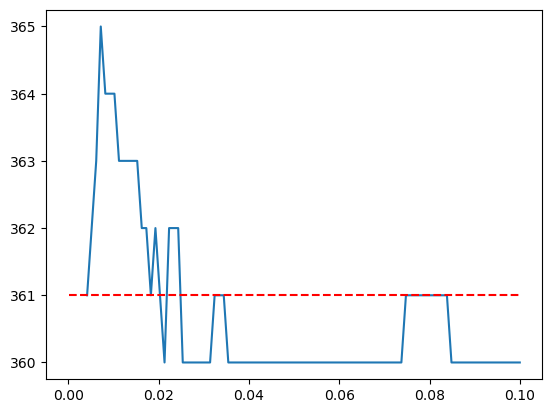

In [234]:
plt.plot(eps_linspace[4:], num_clusters[4:], label='DBSCAN number of clusters')
plt.hlines(19**2, eps_linspace[0],eps_linspace[-1], colors='r', linestyles='dashed', label='True number of columns')


In [237]:
def oreinted_mean(z):
    z_inners=np.inner(z,z.conj())
    ret_z=[]
    for  i in range(z.shape[0]):
        if z_inners[0,i]>0:
            ret_z.append(z[i])
        else:
            ret_z.append(-z[i])
    return np.mean(np.array(ret_z), axis=0)

T_hold=.99

IND=1
print(eps_linspace[IND], num_clusters[IND])
DBSCAN_fit=DBSCAN(eps=eps_linspace[IND], min_samples=4, metric='precomputed').fit(torch_inner)

ghat_list=[X[DBSCAN_fit.labels_==i][0] for i in range(max(DBSCAN_fit.labels_))]
ghat_list_avgs=[oreinted_mean(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]



medium_hat=np.vstack(ghat_list)
medium_hat=H.cat2complex(medium_hat)
medium_hat=medium_hat/np.linalg.norm(medium_hat, axis=1)[:,None]
torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
max_inners=np.max(torch_inners, axis=0)
print(max_inners[0],max(torch_inners[:,0]),medium_hat.shape)
print(f'num recovered: {len(max_inners[max_inners>T_hold])}, inner avg: {max_inners.mean()}')

medium_hat_avgs=np.vstack(ghat_list_avgs)
medium_hat_avgs=H.cat2complex(medium_hat_avgs)
medium_hat_avgs=medium_hat_avgs/np.linalg.norm(medium_hat_avgs, axis=1)[:,None]
torch_inners_avgs=np.abs(np.inner(medium_hat_avgs,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
max_inners_avgs=np.max(torch_inners_avgs, axis=0)
print(max_inners_avgs[0],max(torch_inners_avgs[:,0]))
print(f'num recovered: {len(max_inners_avgs[max_inners_avgs>T_hold])}, inner avg: {max_inners_avgs.mean()}')
ind_not_recovered_list.append(np.where(max_inners_avgs<T_hold)[0])


0.0011090909090909092 360
0.9998468939148394 0.9998468939148394 (362, 806)
num recovered: 361, inner avg: 0.9996815988871028
0.9999268813432458 0.9999268813432458
num recovered: 361, inner avg: 0.9998695008923068


In [177]:
ind_not_recovered_list


[array([61]), array([61]), array([59]), array([59]), array([59])]

0.007500000000000001 365


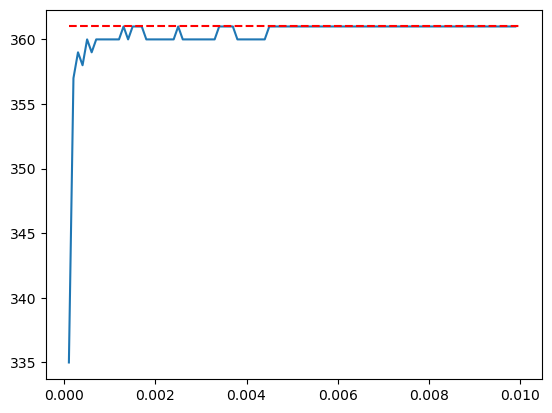

In [12]:
def oreinted_mean(z):
    z_inners=np.inner(z,z.conj())
    ret_z=[]
    for  i in range(z.shape[0]):
        if z_inners[0,i]>0:
            ret_z.append(z[i])
        else:
            ret_z.append(-z[i])
    return np.mean(np.array(ret_z), axis=0)

T_hold=.99
IND=-26
num_recovered_list=[]

print(eps_linspace[IND], num_clusters[IND])
ind_not_recovered_list=[]
for eps in eps_linspace:
    DBSCAN_fit=DBSCAN(eps=eps, min_samples=5, metric='precomputed').fit(torch_inner)
    cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
    sorted_cluster_sizes=sorted(cluster_sizes)
    try:
        min_accepted_cluster_size=sorted_cluster_sizes[-361]
    except:
        min_accepted_cluster_size=0
    if len(cluster_sizes)>min_accepted_cluster_size:
        ghat_list=[]
        ghat_list_avgs=[]
        for i in range(max(DBSCAN_fit.labels_)):
            if cluster_sizes[i]>=5:
                
                ghat_list.append(X[DBSCAN_fit.labels_==i][0])
                ghat_list_avgs.append(oreinted_mean(X[DBSCAN_fit.labels_==i]))



        medium_hat=np.vstack(ghat_list)
        medium_hat=H.cat2complex(medium_hat)
        medium_hat=medium_hat/np.linalg.norm(medium_hat, axis=1)[:,None]
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
        max_inners=np.max(torch_inners, axis=0)
        #print(max_inners[0],max(torch_inners[:,0]),medium_hat.shape)
        #print(f'num recovered: {len(max_inners[max_inners>T_hold])}, inner avg: {max_inners.mean()}')

        medium_hat_avgs=np.vstack(ghat_list_avgs)
        medium_hat_avgs=H.cat2complex(medium_hat_avgs)
        medium_hat_avgs=medium_hat_avgs/np.linalg.norm(medium_hat_avgs, axis=1)[:,None]
        torch_inners_avgs=np.abs(np.inner(medium_hat_avgs,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
        max_inners_avgs=np.max(torch_inners_avgs, axis=0)
        #print(max_inners_avgs[0],max(torch_inners_avgs[:,0]))
        #print(f'num recovered: {len(max_inners_avgs[max_inners_avgs>T_hold])}, inner avg: {max_inners_avgs.mean()}')
        num_recovered_list.append(len(max_inners_avgs[max_inners_avgs>T_hold]))
        if len(max_inners_avgs[max_inners_avgs>T_hold])>=360:
            ind_not_recovered_list.append(np.where(max_inners_avgs<T_hold)[0])

plt.plot(eps_linspace[:len(num_recovered_list)], num_recovered_list, label='Recovery number of columns')
plt.hlines(19**2, eps_linspace[0],eps_linspace[len(num_recovered_list)], colors='r', linestyles='dashed', label='True number of columns')        
#ind_not_recovered_list=[i[0] for i in ind_not_recovered_list]

#print(f'indices missed:{set(ind_not_recovered_list)}')
#plt.hists(ind_not_recovered_list)                    
                            

In [9]:
print(sorted_cluster_sizes[:15], len(sorted_cluster_sizes))


[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4] 418


[364,
 364,
 364,
 366,
 366,
 366,
 364,
 364,
 364,
 364,
 364,
 364,
 363,
 363,
 363,
 363,
 362,
 361,
 361,
 361,
 361,
 361,
 361,
 360,
 360,
 361,
 361,
 361,
 361,
 361]

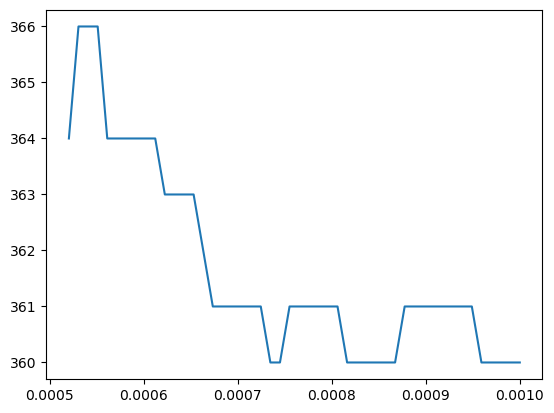

In [111]:
ghat_list=[]
print(cluster_sizes)
for i in range(len(cluster_sizes)):
    if cluster_sizes[i]>4:
        ghat_list.append(X[DBSCAN_fit.labels_==i][0])

medium_hat=np.vstack(ghat_list)
medium_hat=H.cat2complex(medium_hat)   
print(medium_hat.shape)

torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
max_inners=np.max(torch_inners, axis=0)
print(max_inners[0],max(torch_inners[:,0]))
len(max_inners[max_inners>.99]),max_inners.mean()

In [127]:
T_hold=.9
IND=num_clusters.index(19**2)
print(eps_linspace[IND], num_clusters[IND])
DBSCAN_fit=DBSCAN(eps=eps_linspace[IND], min_samples=5, metric='precomputed').fit(torch_inner)

ghat_list=[X[DBSCAN_fit.labels_==i][0] for i in range(max(DBSCAN_fit.labels_))]
ghat_list_avgs=[np.mean(X[DBSCAN_fit.labels_==i],axis=0) for i in range(max(DBSCAN_fit.labels_))]



medium_hat=np.vstack(ghat_list)
medium_hat=H.cat2complex(medium_hat)
medium_hat=medium_hat/np.linalg.norm(medium_hat, axis=1)[:,None]
torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
max_inners=np.max(torch_inners, axis=0)
print(max_inners[0],max(torch_inners[:,0]),medium_hat.shape)
print(f'num recovered: {len(max_inners[max_inners>T_hold])}, inner avg: {max_inners.mean()}')

medium_hat_avgs=np.vstack(ghat_list_avgs)
medium_hat_avgs=H.cat2complex(medium_hat_avgs)
medium_hat_avgs=medium_hat_avgs/np.linalg.norm(medium_hat_avgs, axis=1)[:,None]
torch_inners_avgs=np.abs(np.inner(medium_hat_avgs,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
max_inners_avgs=np.max(torch_inners_avgs, axis=0)
print(max_inners_avgs[0],max(torch_inners_avgs[:,0]))
print(f'num recovered: {len(max_inners_avgs[max_inners_avgs>T_hold])}, inner avg: {max_inners_avgs.mean()}')


ValueError: 361 is not in list

In [28]:

index_list=[]
sum_max_inner_original=0
max_list=[]
for i in range(361):
    max_list.append(max(torch_inners[:, i]))
    if max(torch_inners[:, i])>.99 and i not in index_list:
        index_list.append(i)
    sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
max_avg_inners_original=sum_max_inner_original/361

min(max_inners),max_avg_inners_original,len(index_list),min(max_list)

(0.8403316334349994, 0.9941712286307979, 332, 0.7285845403287607)

shape of the union without removin: (18050, 806), number for Expceriments: 50
(806,)
41 12
44 9
60 12
61 12
66 10
[9, 10, 12, 12, 12]


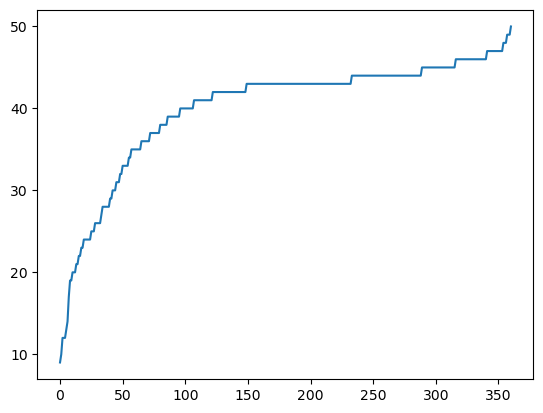

In [178]:
col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(361):
    G_i=medium.T[i]
    print(G_i.shape)
    break
col_list=get_cluster_data(decoder_locats)
num_times_recovered_list=[]
inn_list_max_list=[]
for i in range(361):
    G_i=medium.T[i]
    inn_list=abs(np.inner(G_i, col_list.conj()))
    inn_list_max_list.append(np.max(inn_list))
    num_times_recovered=len(inn_list[inn_list>.99])
    num_times_recovered_list.append(num_times_recovered)
    if num_times_recovered<=12:
        print(i, num_times_recovered)

num_times_recovered_list=sorted(num_times_recovered_list)
num_times_recovered_list[:5]
plt.plot([i for i in range(361)], num_times_recovered_list)
print(num_times_recovered_list[:5],)

In [41]:
col_list=get_cluster_data(decoder_locats)
num_times_recovered_list=[]
inn_list_max_list=[]
G_i=medium.T[0]
G_i_hats=[]

for i in col_list:
    inn_list=abs(np.inner(G_i, i.conj()))
    if inn_list>.99:
        G_i_hats.append(i)
#    num_times_recovered_list.append(num_times_recovered)

G_i_hat_distanced=[np.sum(abs(G_i_hat-G_i)**2)**(1/2) for G_i_hat in G_i_hats]
G_i_hat_inners=[abs(np.inner(G_i_hat, G_i.conj())) for G_i_hat in G_i_hats]
G_i_hat_inners.sort()
G_i_hat_distanced.sort()
G_i_hat_distanced[-5:], G_i_hat_inners[-5:]

43

In [46]:
G_i_hat_distanced=[np.sum(abs(G_i_hat-G_i)**2)**(1/2) for G_i_hat in G_i_hats]
G_i_hat_inners=[abs(np.inner(G_i_hat, G_i.conj())) for G_i_hat in G_i_hats]
G_i_hat_inners.sort()
G_i_hat_distanced.sort()
G_i_hat_distanced[-5:], G_i_hat_inners[-5:]

([1.9194813665275472,
  1.9197723004371443,
  1.9199803011417733,
  1.9200232178917622,
  1.920425191581124],
 [0.9998732206371255,
  0.9998767896145772,
  0.9998785387632312,
  0.9998793854259006,
  0.999890047524533])

In [37]:
len(G_i_hat_indices), len(G_i_hat_distanced)

(18050, 18050)

In [38]:
G_i_hat_indices

array([False, False, False, ..., False, False, False])

In [34]:
for i in col_list:
    if not np.allclose((abs(i)**2).sum(),1):
        print('wtf')

In [ ]:
/Users/alexchristie/Downloads/Codes_data/FoldyLox_all_seeds/FoldyLox_seed1
scp -r /Users/alexchristie/Downloads/Codes_data/FoldyLox_all_seeds/FoldyLox_seed1 achristie@gp-workstation2:/home/achristie/RM_imaging/Data/FoldyLox_all_seeds/   